In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
# %cd /gdrive/MyDrive/Colab Notebooks/dataset
# !unzip -qq "/gdrive/MyDrive/Colab Notebooks/dataset/archive.zip"

In [ ]:
import tensorflow as tf
model = tf.keras.models.load_model('/gdrive/MyDrive/Colab Notebooks/best_model_vgg16')

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.15)

test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    '/gdrive/MyDrive/tmp/BrainTumor/Training',
    target_size=(200, 200),
    shuffle=True,
    batch_size=64,
    class_mode='categorical', # one hot encoding
    subset='training'
)

valid_gen = train_datagen.flow_from_directory(
    '/gdrive/MyDrive/tmp/BrainTumor/Training',
    target_size=(200, 200),
    shuffle=True,
    batch_size=64,
    class_mode='categorical', # one hot encoding
    subset='validation'
)

test_gen = test_datagen.flow_from_directory(
    '/gdrive/MyDrive/tmp/BrainTumor/Testing',
    target_size=(200, 200),
    batch_size=64,
    class_mode='categorical'
)


Found 2441 images belonging to 4 classes.
Found 429 images belonging to 4 classes.
Found 394 images belonging to 4 classes.


In [ ]:
n_img = train_gen.n
steps = n_img // 32
imgs, labels = [], []
for i in range(steps):
    a, b = train_gen.next()
    imgs.extend(a)
    labels.extend(b)

imgs = np.asarray(imgs)
labels = np.asarray(labels)

In [ ]:
x_train, y_train = train_gen.next()
x_test, y_test = test_gen.next()

In [ ]:
# copy from https://gist.github.com/stared/dfb4dfaf6d9a8501cd1cc8b8cb806d2e

from IPython.display import clear_output
from tensorflow.keras.callbacks import Callback

class PlotLosses(Callback):

  def on_train_begin(self, logs={}):
    self.epochs = []
    self.losses = []
    self.val_losses = []
    self.logs = []
    self.fig = plt.figure()


  def on_epoch_end(self, epoch, logs={}):

    self.epochs.append(epoch)
    self.losses.append(logs.get('loss'))
    self.val_losses.append(logs.get('val_loss'))

    clear_output(wait=True)
    plt.plot(self.epochs, self.losses, label="loss")
    plt.plot(self.epochs, self.val_losses, label="val_loss")
    plt.legend()
    plt.show();
    print("loss = ", self.losses[-1], ", val_loss = ", self.val_losses[-1])

In [ ]:
from tensorflow.keras.applications import EfficientNetB3 # VGG16
EfficientNet=EfficientNetB3(weights='imagenet', include_top=False, input_shape=(200,200,3))

43950080/43941136 [==============================] - 0s 0us/step


In [ ]:
from tensorflow.keras.applications import VGG16
VGG16=VGG16(weights='imagenet', include_top=False, input_shape=(200,200,3))

58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pyplot
import tensorflow as tf
from tensorflow.keras.layers import Flatten, Dense, Dropout, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras import Sequential
from tensorflow.keras.regularizers import l2

model = Sequential([
    VGG16,
    # Conv2D(128, (3, 3), input_shape=(256, 256, 3), padding='same', activation='relu'),
    # MaxPooling2D(2, 2),
    # Conv2D(64, (3, 3), activation='relu', padding='same'),
    # MaxPooling2D(2, 2),    
    # Conv2D(64, (3, 3), activation='relu', padding='same'),
    # MaxPooling2D(2, 2),
    # Conv2D(64, (3, 3), activation='relu', padding='same'),
    # MaxPooling2D(2, 2),
    # BatchNormalization(),
    Flatten(), 
    # Dropout(0.3),
    Dense(64, activation='relu', kernel_regularizer=l2()),
    Dropout(0.3),
    # Dense(256, activation='relu'),
    # Dropout(0.3),    
    # Dense(64, activation='relu'),
    # Dropout(0.3),    
    # Dense(32, activation='relu'),
    # Dropout(0.3),    
    # Dense(32, activation='relu'),
    # Dropout(0.3),    
    Dense(16, activation='relu', kernel_regularizer=l2()),
    BatchNormalization(),
    Dropout(0.3),
    # Dense(32, activation='relu')
    Dense(4, activation='softmax')
])


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 6, 6, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 18432)             0         
                                                                 
 dense (Dense)               (None, 64)                1179712   
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 16)                1040      
                                                                 
 batch_normalization (BatchN  (None, 16)               64        
 ormalization)                                                   
                                                        

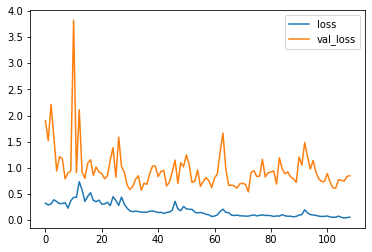

loss =  0.05587974935770035 , val_loss =  0.8487363457679749

Epoch 109: val_loss did not improve from 0.53944
39/39 [==============================] - 33s 834ms/step - loss: 0.0559 - accuracy: 0.9922 - val_loss: 0.8487 - val_accuracy: 0.8555 - lr: 0.0012
Epoch 110/200
29/39 [=====================>........] - ETA: 6s - loss: 0.0545 - accuracy: 0.9928

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

checkpoint=ModelCheckpoint('best_model2_vgg16.h5', monitor='val_loss', save_best_only=True, verbose=1)
optimizer = Adam(learning_rate=0.01)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=20, factor=0.5, verbose=1, min_learning_rate=0.0001)
plot_losses = PlotLosses()

train_history = model.fit(train_gen, epochs=200, validation_data = valid_gen, verbose=1, callbacks=[plot_losses, reduce_lr, checkpoint])
test_history = model.evaluate(test_gen)

In [ ]:
test_history

In [ ]:
model = tf.keras.models.load_model('best_model_vgg16.h5')

In [ ]:
model.save('/gdrive/MyDrive/Colab Notebooks/best_model_vgg16/')